In [32]:
import cv2
import glob
import os
import re
import sys
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from xml.dom import minidom

In [ ]:
!git clone https://github.com/thegrandpoobah/voronoi

Cloning into 'voronoi'...
remote: Enumerating objects: 537, done.
remote: Total 537 (delta 0), reused 0 (delta 0), pack-reused 537
Receiving objects: 100% (537/537), 4.36 MiB | 271.00 KiB/s, done.
Resolving deltas: 100% (327/327), done.


In [ ]:
!make -C voronoi

Makefile    corpus      picopng     voronoi     voronoi.sln
README.md   license.txt stippler    voronoi.bat
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c picopng/picopng.cpp -o picopng/picopng.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c stippler/bitmap.cpp -o stippler/bitmap.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c stippler/stippler_api.cpp -o stippler/stippler_api.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c stippler/stippler.cpp -o stippler/stippler.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c stippler/VoronoiDiagramGenerator.cpp -o stippler/VoronoiDiagramGenerator.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c voronoi/parse_arguments.cpp -o voronoi/parse_arguments.o
c++ -Wall -fpermissive  -O2 -I./picopng -I./stippler -I./voronoi -c voronoi/voronoi.cpp -o voronoi/voronoi.o
In file included from voronoi/voronoi.cpp:42:
/usr/local/includ

In [ ]:
!git clone https://github.com/PanyshevAlex/traveling-salesman

Cloning into 'traveling-salesman'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 56 (delta 0), reused 2 (delta 0), pack-reused 50
Receiving objects: 100% (56/56), 22.56 KiB | 563.00 KiB/s, done.
Resolving deltas: 100% (25/25), done.


In [1]:
!make -C traveling-salesman

g++ -O2 -DNDEBUG -ftree-vectorize -Wall -c algorithms.cpp
g++ -O2 -DNDEBUG -ftree-vectorize -Wall main.o city.o tree.o algorithms.o -o tsp


In [ ]:
!git clone https://github.com/beckysag/traveling-salesman traveling_salesman_2

Cloning into 'traveling_salesman_2'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Receiving objects: 100% (49/49), 454.23 KiB | 597.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!make -C traveling_salesman_2

g++ -g -Wall -c -MMD -MP -MF"MyThread.d" -MT"MyThread.d" -o "MyThread.o" "MyThread.cpp"
g++ -g -Wall -c -MMD -MP -MF"main.d" -MT"main.d" -o "main.o" "main.cpp"
g++ -g -Wall -c -MMD -MP -MF"threads.d" -MT"threads.d" -o "threads.o" "threads.cpp"
g++ -g -Wall -c -MMD -MP -MF"tsp.d" -MT"tsp.d" -o "tsp.o" "tsp.cpp"
g++ -g -Wall -c -MMD -MP -MF"twoOpt.d" -MT"twoOpt.d" -o "twoOpt.o" "twoOpt.cpp"
g++  -o "tsp" MyThread.o main.o threads.o tsp.o twoOpt.o -lm -L/usr/include -lpthread 


In [33]:
# Разбиваем видео на кадры
def video_to_frames(path):
    videoCapture = cv2.VideoCapture()
    videoCapture.open(path)
    fps = videoCapture.get(cv2.CAP_PROP_FPS) 
    frames = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
    print("fps=", int(fps), "frames=", int(frames))
    count = 0
    for i in range(int(frames)-1):
        ret, frame = videoCapture.read()
        if type(frame) != type(None):
            cv2.imwrite("source/frames/%d.png"%(i), frame)
            count += 1
    return count

# создание файла для tsp solver формата: index x_coord y_coord 
def create_tsp(path, dest):
    doc = minidom.parse(path)
    circe_x = [path.getAttribute('cx') for path
                    in doc.getElementsByTagName('circle')]
    circe_y = [path.getAttribute('cy') for path
                    in doc.getElementsByTagName('circle')]
    f = open(dest, "w")
    for i in range(len(circe_x)):
        f.write(str(i) + " " + str(int(float(circe_x[i]))) + " " + str(int(float(circe_y[i]))) + "\n")

# создание svg файла решения по точечному изображению и решению tsp
def tsppng(frame, tappath, dest):
    f = open(tappath)
    tsppath = f.readlines()
    ff = open(frame)
    tspcoord = ff.readlines()
    tspcoord = [x.split() for x in tspcoord]
    svg_path = '''<path d="M{} {} '''.format(tspcoord[int(tsppath[1])][1], tspcoord[int(tsppath[1])][2])
    print(svg_path)
    for i in range(2, len(tsppath)):
        svg_path += "L {} {} ".format(tspcoord[int(tsppath[i])][1], tspcoord[int(tsppath[i])][2])
    #svg_path += '''L {} {} '''.format(tspcoord[int(tsppath[1])][1], tspcoord[int(tsppath[1])][2])
    svg_path += '''" stroke="black" stroke-width="3" fill="none"/> \n </svg>'''
    f = open(dest, "a")
    f.write('''<?xml version="1.0" ?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg width="1080" height="934" version="1.1" xmlns="http://www.w3.org/2000/svg">\n''')
    f.write(svg_path)
    f.close()
    ff.close()



In [34]:
# Полная обработка видео
def solve_video(path, N):
    frames = video_to_frames(path) # разбиваем ка кадры
    
    comm = "./voronoi/voronoi_stippler -I source/frames/{}.png -O source/tippled_frames/{}.svg -s {} -t 0.4 -z 0.5" # команда для запуска voronoi-stippler
    # для каждого кадра создаем точечное изображение
    for i in range(frames):
        os.system(comm.format(i,i, N))
    
    # конвертируем точечные изображения в png 
    for i in range(1,frames):
        filename = "source/tippled_frames/{}.svg".format(i)
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, "source/tippled_frames_png/{}.png".format(i), fmt="PNG")

    # создаем промежуточное точечное видео 
    img_array = []

    for i in range(frames):
        filename = "source/tippled_frames_png/{}.png".format(i)
        img = cv2.imread(filename)
        if type(img) != type(None):
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

    video_out = cv2.VideoWriter('stippled.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 24, size)

    for i in range(len(img_array)):
        video_out.write(img_array[i])
    video_out.release()

    # подготавливаем данные для tsp solver 
    for i in range(frames):
        create_tsp("source/tippled_frames/{}.svg".format(i), "source/tsp_frames/{}.tsp".format(i))
    
    # решаем tsp через nearest neighbour + 2-opt
    os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(0, 0))
    for i in range(1, frames):
        os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour source/tsp_frames/{}.tsp".format(i, i, i-1, i-1))


    # создаем svg решения
    for i in range(frames):
        tsppng("source/tsp_frames/{}.tsp".format(i), "source/tsp_path/{}.tsp.tour".format(i), "source/final_frames/{}.svg".format(i))

    # конвертируем svg в png
    for i in range(frames):
        filename = "source/final_frames/{}.svg".format(i)
        drawing = svg2rlg(filename)
        renderPM.drawToFile(drawing, "source/final_frames_png/{}.png".format(i), fmt="PNG")

    # собираем результат в видео
    img_array = []

    for i in range(1,frames):
        filename = "source/final_frames_png/{}.png".format(i)
        img = cv2.imread(filename)
        if type(img) != type(None):
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

    video_out = cv2.VideoWriter('stippled_tspart.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 24, size)

    for i in range(len(img_array)):
        video_out.write(img_array[i])
    video_out.release()

    
    

In [35]:
solve_video("source/test1.mp4", 1500)

fps= 24 frames= 142
Generating 1500 stipples.
Options: Black stipples, overlapping stipples, Variable radius, Subpixel density of 5, Sizing factor of 0.5, Displacement Threshold of 0.4
7.70% Complete
18.15% Complete
27.08% Complete
36.23% Complete
44.74% Complete
52.89% Complete
60.29% Complete
67.15% Complete
73.67% Complete
79.21% Complete
85.18% Complete
92.72% Complete
100.00% Complete
Completed in 5.20 seconds.
Generating 1500 stipples.
Options: Black stipples, overlapping stipples, Variable radius, Subpixel density of 5, Sizing factor of 0.5, Displacement Threshold of 0.4
7.68% Complete
17.84% Complete
27.31% Complete
36.71% Complete
45.49% Complete
53.61% Complete
61.26% Complete
68.20% Complete
74.10% Complete
79.23% Complete
85.18% Complete
92.12% Complete
97.78% Complete
100.00% Complete
Completed in 5.63 seconds.
Generating 1500 stipples.
Options: Black stipples, overlapping stipples, Variable radius, Subpixel density of 5, Sizing factor of 0.5, Displacement Threshold of 0.4

[ WARN:0@41867.856] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('source/tippled_frames_png/0.png'): can't open/read file: check file path/integrity
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Writing solution 35331
im here

im here

im here

41 46 78
Writing solution 35342
im here

257 46 78
Writing solution 35343
im here

45 46 78
Writing solution 34495
im here

321 46 78
Writing solution 34490
im here

228 46 78
Writing solution 34502
im here

36 43 78
Writing solution 35933
im here

1392 15 125
Writing solution 35945
im here

1391 15 125
Writing solution 35942
im here

1370 15 125
Writing solution 35926
im here

1374 15 125
Writing solution 35412
im here

1397 15 125
Writing solution 35070
im here

1392 15 125
Writing solution 35292
im here

1396 15 125
Writing solution 35526
im here

1450 15 125
Writing solution 35915
im here

1416 14 125
Writing solution 35489
im here

1405 14 125
Writing solution 35488
im here

1408 15 125
Writing solution 36051
im here

1394 15 125
Writing solution 36050
im here

1429 14 125
Writing solution 35214
im here

1426 14 125
Writing solution 35547
im here

1423 14 125
Writing solution 36280
im here

1422 14 125
Writing solution 36290
im her

FileNotFoundError: [Errno 2] No such file or directory: 'source/tsp_path/0.tsp.tour'

### Сравнение двух методов: nearest neighbour + 2-opt и  Christofides’ algorithm + 2-opt

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np

In [ ]:

time_nearest = []
time_christofides = []
f = open("source/tsp_frames/0.tsp")
tsp_inpit = f.readlines()
for i in range(30): 
        ff = open("source/tsp_frames/temp.tsp", "a")
        for j in range(50):
            ff.write(tsp_inpit[50*i+j])
        ff.close()
        stime = time.time()
        os.system("./traveling-salesman/tsp source/tsp_frames/temp.tsp source/tsp_path/firsttime.tsp.tour")
        etime = time.time()
        time_nearest.append(etime-stime)

        stime = time.time()
        os.system("./traveling_salesman_2/tsp source/tsp_frames/temp.tsp")
        etime = time.time()
        time_christofides.append(etime-stime)
        print(time_nearest[i], time_christofides[i])

In [110]:
N = np.linspace(50, 1500, 30)
plt.plot(N, time_nearest, label="nearest neighbour")
plt.plot(N, time_christofides, label="Christofides algorithm")
plt.xlabel("N")
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()




NameError: name 'time_nearest' is not defined

In [2]:
os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour".format(1, 1, 0))
#os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(1, 1))

source/tsp_path/0.tsp.tourwrititit
0
710
1169
957
360
1160
69
763
1445
72
48
46
323
55
36
22
10
15
27
1419
1347
40
137
508
78
222
303
833
43
26
341
6
1327
39
298
889
1
17
30
44
49
41
25
16
2
334
270
523
53
51
863
38
145
1313
234
71
13
9
1012
903
83
23
24
1209
29
629
157
60
59
64
756
819
252
42
1431
1430
1210
1469
1467
114
117
304
152
174
197
212
214
191
1077
158
133
1089
1086
978
879
440
264
796
519
1097
1100
491
413
325
382
421
456
1126
477
484
1459
367
971
685
990
265
584
626
541
168
424
159
125
123
1216
218
167
645
209
255
948
379
444
494
544
652
591
631
585
670
637
617
598
1128
625
620
1406
649
1072
691
648
1099
1022
1251
790
775
735
1498
881
803
760
737
728
1482
1234
624
599
640
674
547
597
622
536
659
546
653
1356
636
580
607
777
610
558
1385
690
1152
593
602
679
639
681
657
671
642
586
643
893
1359
483
435
414
847
393
395
1236
365
1446
324
604
968
273
1245
1358
246
240
837
267
281
702
378
1432
445
865
834
449
401
405
346
1399
933
1028
846
204
239
198
307
195
1055
163
180
172
409

0

In [7]:
tsppng("source/tsp_frames/{}.tsp".format(1), "source/tsp_path/{}.tsp.tour".format(1), "source/final_frames/{}.svg".format(1))

<path d="M48 14 


In [10]:
!git clone https://github.com/ReScience-Archives/Rougier-2017

Cloning into 'Rougier-2017'...
remote: Enumerating objects: 345, done.
remote: Total 345 (delta 0), reused 0 (delta 0), pack-reused 345
Receiving objects: 100% (345/345), 157.25 MiB | 639.00 KiB/s, done.
Resolving deltas: 100% (160/160), done.


In [14]:
os.system("python3 Rougier-2017/code/stippler.py --n_iter 10 --n_point 1000 --display source/frames/0.png")


Nb points: 1000
Nb iterations: 10
Density file: source/frames/0.png (resized to 1270x720)
Output file (PDF): source/frames/0-stipple.pdf 
            (PNG): source/frames/0-stipple.png 
            (DAT): source/frames/0-stipple.npy 


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Figure(600x340.157)


0

In [76]:
%matplotlib inline
from Rougier.code.stippler import initialization, normalize
from Rougier.code.voronoi import centroids
import tqdm
import os.path
import scipy.misc
import scipy.ndimage
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [97]:
def make_tsp_by_points(path, points):
    f = open(path, "w")
    points = sorted(points, key=lambda x: x[0]+x[1])
    out = []
    temp = np.copy(points)
    out.append(temp[0])
    temp = np.delete(temp, 0, 0)
    current_num = len(temp) 
    closest_index = 0
    while current_num != 0:
        closest = 99999
        for i in range(current_num):
            current_dist = (temp[i][0]-out[-1][0])**2+(temp[i][1]-out[-1][1])**2
            if current_dist < closest:
                closest = current_dist
                closest_index = i
        closest_index = 0
        out.append(temp[closest_index])
        temp = np.delete(temp, closest_index, 0)
        current_num -= 1


    #points = sorted(points, key=lambda x: x[0]+x[1])
    for i in range(len(out)):
        f.write("{} {} {}\n".format(i, int(out[i][0]), int(out[i][1])))
    

In [137]:
frames = video_to_frames("source/test5.mp4")

fps= 24 frames= 164


In [138]:
n_point = 1500
threshold = 255
n_iter = 10
figsize = 6
pointsize = (1.0, 1.0)

filename = "source/frames/0.png"
density = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
zoom = (n_point * 500) / (density.shape[0]*density.shape[1])
zoom = int(round(np.sqrt(zoom)))
density = scipy.ndimage.zoom(density, zoom, order=0)

density = np.minimum(density, threshold)

density = 1.0 - normalize(density)
density = density[::-1, :]
density_P = density.cumsum(axis=1)
density_Q = density_P.cumsum(axis=1)

dirname = os.path.dirname(filename)
basename = (os.path.basename(filename).split('.'))[0]
pdf_filename = os.path.join(dirname, basename + "-stipple.pdf")
png_filename = os.path.join(dirname, basename + "-stipple.png")
dat_filename = os.path.join(dirname, basename + "-stipple.npy")

points = initialization(n_point, density)

xmin, xmax = 0, density.shape[1]
ymin, ymax = 0, density.shape[0]
bbox = np.array([xmin, xmax, ymin, ymax])
ratio = (xmax-xmin)/(ymax-ymin)

for i in tqdm.trange(30):
    regions, points = centroids(points, density, density_P, density_Q)

fig = plt.figure(figsize=(figsize, figsize/ratio), facecolor="white")

ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim([xmin, xmax])
ax.set_xticks([])
ax.set_ylim([ymin, ymax])
ax.set_yticks([])
scatter = ax.scatter(points[:, 0], points[:, 1], s=1, facecolor="k", edgecolor="None")
Pi = points.astype(int)
X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
sizes = (pointsize[0] + (pointsize[1]-pointsize[0])*density[Y, X])
scatter.set_offsets(points)
scatter.set_sizes(sizes)
#np.save(dat_filename, points)
#plt.savefig(pdf_filename)
plt.savefig(png_filename)
plt.close(fig)
make_tsp_by_points("source/tsp_frames/0.tsp", points)

100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


In [139]:
def referring_stippler(filename, points):
    density = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    zoom = (n_point * 500) / (density.shape[0]*density.shape[1])
    zoom = int(round(np.sqrt(zoom)))
    density = scipy.ndimage.zoom(density, zoom, order=0)

    density = np.minimum(density, threshold)

    density = 1.0 - normalize(density)
    density = density[::-1, :]
    density_P = density.cumsum(axis=1)
    density_Q = density_P.cumsum(axis=1)

    dirname = os.path.dirname(filename)
    basename = (os.path.basename(filename).split('.'))[0]
    #pdf_filename = os.path.join(dirname, basename + "-stipple.pdf")
    png_filename = os.path.join(dirname, basename + "-stipple.png")
    #dat_filename = os.path.join(dirname, basename + "-stipple.npy")

    #points = initialization(n_point, density)

    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    bbox = np.array([xmin, xmax, ymin, ymax])
    ratio = (xmax-xmin)/(ymax-ymin)

    for i in range(n_iter):
        regions, points = centroids(points, density, density_P, density_Q)
    fig = plt.figure(figsize=(figsize, figsize/ratio), facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim([xmin, xmax])
    ax.set_xticks([])
    ax.set_ylim([ymin, ymax])
    ax.set_yticks([])
    scatter = ax.scatter(points[:, 0], points[:, 1], s=1, facecolor="k", edgecolor="None")
    Pi = points.astype(int)
    X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
    Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
    sizes = (pointsize[0] + (pointsize[1]-pointsize[0])*density[Y, X])
    scatter.set_offsets(points)
    scatter.set_sizes(sizes)
    #np.save(dat_filename, points)
    #plt.savefig(pdf_filename)
    plt.savefig(png_filename)
    time.sleep(0.1)
    plt.close(fig)
    return points

In [140]:
for i in tqdm.trange(1, 149):
    points = referring_stippler("source/frames/{}.png".format(i), points)
    make_tsp_by_points("source/tsp_frames/{}.tsp".format(i), points)
    

 78%|███████▊  | 116/148 [20:07<05:33, 10.41s/it]
[ WARN:0@98943.920] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('source/frames/117.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [144]:

frames = 117
os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(0, 0))
for i in range(1, frames):
    os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour source/tsp_frames/{}.tsp".format(i, i, i-1, i-1))


# создаем svg решения
for i in range(frames):
    tsppng("source/tsp_frames/{}.tsp".format(i), "source/tsp_path/{}.tsp.tour".format(i), "source/final_frames/{}.svg".format(i))

# конвертируем svg в png
for i in range(frames):
    filename = "source/final_frames/{}.svg".format(i)
    drawing = svg2rlg(filename)
    renderPM.drawToFile(drawing, "source/final_frames_png/{}.png".format(i), fmt="PNG")

# собираем результат в видео
img_array = []

for i in range(frames):
    filename = "source/final_frames_png/{}.png".format(i)
    img = cv2.imread(filename)
    if type(img) != type(None):
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

video_out = cv2.VideoWriter('stippled_tspart.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 24, size)

for i in range(len(img_array)):
    video_out.write(img_array[i])
video_out.release()

Writing solution 20701
im here

6 83 385
Writing solution 20949
im here

5 84 386
Writing solution 21029
im here

4 85 386
Writing solution 21085
im here

4 86 387
Writing solution 21110
im here

4 87 388
Writing solution 21154
im here

3 89 388
Writing solution 21238
im here

3 91 388
Writing solution 21072
im here

10 94 399
Writing solution 20996
im here

10 95 399
Writing solution 20960
im here

10 97 400
Writing solution 20978
im here

8 99 400
Writing solution 20981
im here

8 101 400
Writing solution 20974
im here

10 103 401
Writing solution 21016
im here

11 104 401
Writing solution 21001
im here

45 103 433
Writing solution 21049
im here

47 105 433
Writing solution 21055
im here

50 108 433
Writing solution 21029
im here

53 110 434
Writing solution 21042
im here

55 113 434
Writing solution 21018
im here

58 115 434
Writing solution 21089
im here

63 118 434
Writing solution 21071
im here

65 120 434
Writing solution 21095
im here

66 123 434
Writing solution 21036
im here


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [28]:
os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour source/tsp_frames/{}.tsp".format(1, 1, 0, 0))

im here

4 32 37
Writing solution 29329


0

In [29]:
tsppng("source/tsp_frames/{}.tsp".format(1), "source/tsp_path/{}.tsp.tour".format(1), "source/tsp_path/{}.svg".format(1))

<path d="M13 9 


In [143]:
!make -C traveling-salesman

g++ -O2 -DNDEBUG -ftree-vectorize -Wall -c algorithms.cpp
g++ -O2 -DNDEBUG -ftree-vectorize -Wall main.o city.o tree.o algorithms.o -o tsp


In [37]:
frames = 138
os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(0, 0))
for i in range(1, frames):
    os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour source/tsp_frames/{}.tsp".format(i, i, i-1, i-1))


    # создаем svg решения
for i in range(frames):
    tsppng("source/tsp_frames/{}.tsp".format(i), "source/tsp_path/{}.tsp.tour".format(i), "source/final_frames/{}.svg".format(i))

    # конвертируем svg в png
for i in range(frames):
    filename = "source/final_frames/{}.svg".format(i)
    drawing = svg2rlg(filename)
    renderPM.drawToFile(drawing, "source/final_frames_png/{}.png".format(i), fmt="PNG")

    # собираем результат в видео
img_array = []

for i in range(1,frames):
    filename = "source/final_frames_png/{}.png".format(i)
    img = cv2.imread(filename)
    if type(img) != type(None):
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

video_out = cv2.VideoWriter('stippled_tspart.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 24, size)

for i in range(len(img_array)):
    video_out.write(img_array[i])
video_out.release()

Writing solution 34171
im here

1471 622 113
Writing solution 35009
im here

1196 558 169
Writing solution 34909
im here

23 542 46
Writing solution 34911
im here

722 542 46
Writing solution 34830
im here

29 542 46
Writing solution 34830
im here

30 542 46
Writing solution 34827
im here

45 548 51
Writing solution 35487
im here

12 663 18
Writing solution 35487
im here

480 663 18
Writing solution 35488
im here

17 663 18
Writing solution 35494
im here

357 663 18
Writing solution 35445
im here

140 663 18
Writing solution 35818
im here

15 663 18
Writing solution 35347
im here

371 658 17
Writing solution 35693
im here

10 519 15
Writing solution 35366
im here

38 570 68
Writing solution 35296
im here

1291 570 68
Writing solution 35299
im here

1219 586 87
Writing solution 35637
im here

66 616 62
Writing solution 35639
im here

39 619 63
Writing solution 35510
im here

1064 580 82
Writing solution 35444
im here

275 580 82
Writing solution 35839
im here

772 580 82
Writing solutio

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [119]:
import time

t1 = []
stime = time.time()
os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(0, 0))
etime = time.time()
t1.append(etime - stime)
for i in range(1, 149):
    os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour source/tsp_path/{}.tsp.tour source/tsp_frames/{}.tsp".format(i, i, i-1, i-1))
    etime = time.time()
    t1.append(etime - stime)

t2 = []
stime = time.time()
for i in range(149):
    os.system("./traveling-salesman/tsp source/tsp_frames/{}.tsp source/tsp_path/{}.tsp.tour".format(i, i))
    etime = time.time()
    t1.append(etime - stime)
print(t1)
print(t2)

Writing solution 9411
im here

20 395 170
Writing solution 9396
im here

20 394 170
Writing solution 9416
im here

20 394 171
Writing solution 9431
im here

20 393 171
Writing solution 9447
im here

20 393 171
Writing solution 9464
im here

20 393 171
Writing solution 9469
im here

20 393 172
Writing solution 9484
im here

20 393 172
Writing solution 9496
im here

20 392 172
Writing solution 9509
im here

20 392 172
Writing solution 9514
im here

20 392 172
Writing solution 9510
im here

20 392 172
Writing solution 9517
im here

20 392 172
Writing solution 9521
im here

20 392 172
Writing solution 9539
im here

20 392 172
Writing solution 9547
im here

20 392 172
Writing solution 9542
im here

20 392 172
Writing solution 9548
im here

20 392 172
Writing solution 9546
im here

20 392 172
Writing solution 9562
im here

20 392 172
Writing solution 9532
im here

20 392 172
Writing solution 9532
im here

20 392 172
Writing solution 9559
im here

20 392 172
Writing solution 9573
im here

20 

149
149
149


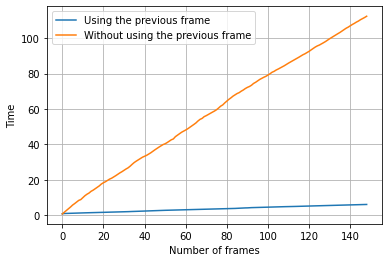

In [136]:
N = np.linspace(0, 148, 149)
print(len(N))
print(len(t1[:149]))
print(len(t1[149:298]))
plt.plot(N, t1[:149], label="Using the previous frame")
plt.plot(N, t1[149:298], label="Without using the previous frame")
plt.xlabel("Number of frames")
plt.ylabel("Time")

plt.grid()
plt.legend()
plt.show()
